In [79]:
import pandas as pd
import requests as r
from pandas.io.json import json_normalize
import pickle

In [80]:
def get_BA_demand(ba_code_list, start_date, end_date, api_key):
    time_interval = pd.date_range(start_date, end_date, tz = "UTC", freq='H')
    df_all = pd.DataFrame(index=time_interval)
    
    for ba in ba_code_list:
        try:
            response = r.get('https://api.eia.gov/series/?api_key=' + api_key + '&series_id=EBA.' + ba + '-ALL.D.H')

            df = json_normalize(response.json(),['series','data'])
            df.columns = ['datetime', ba]

            df.index = pd.to_datetime(df['datetime'])
            df.drop(columns=['datetime'], inplace=True)
            df_all = pd.concat([df_all, df], join='outer', axis=1)
            
        except Exception as e:
            print(ba + ' not found')
    
    return df_all

In [104]:
df_MISO.to_csv('miso.csv')
df.to_csv('original.csv')
demand_interpolated.to_csv('interpol.csv')

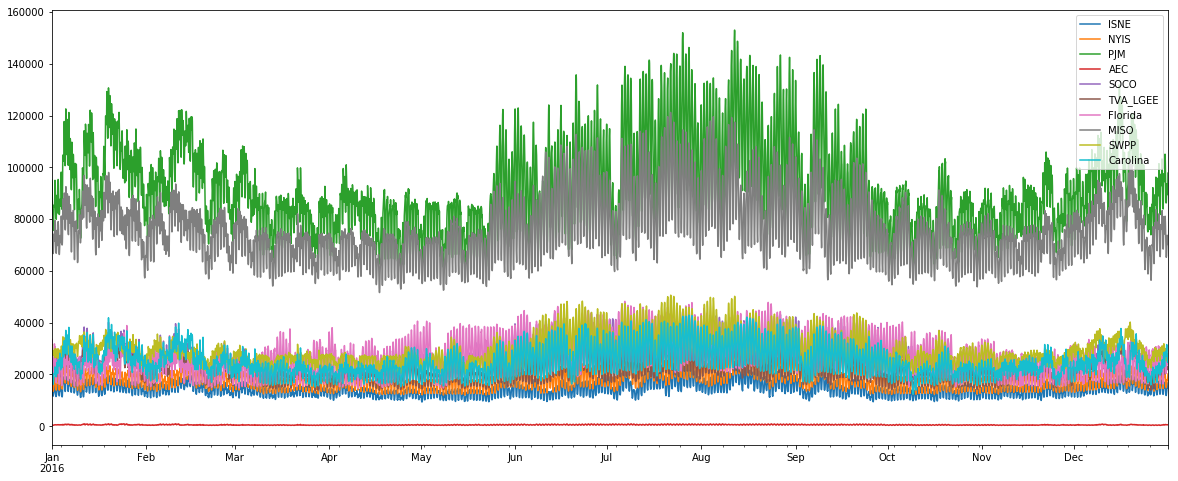

In [106]:
demand_interpolated.plot(figsize = (20,8))

Index(['ISNE', 'NYIS', 'PJM', 'AEC', 'SOCO', 'TVA_LGEE', 'Florida', 'MISO',
       'SWPP', 'Carolina'],
      dtype='object')

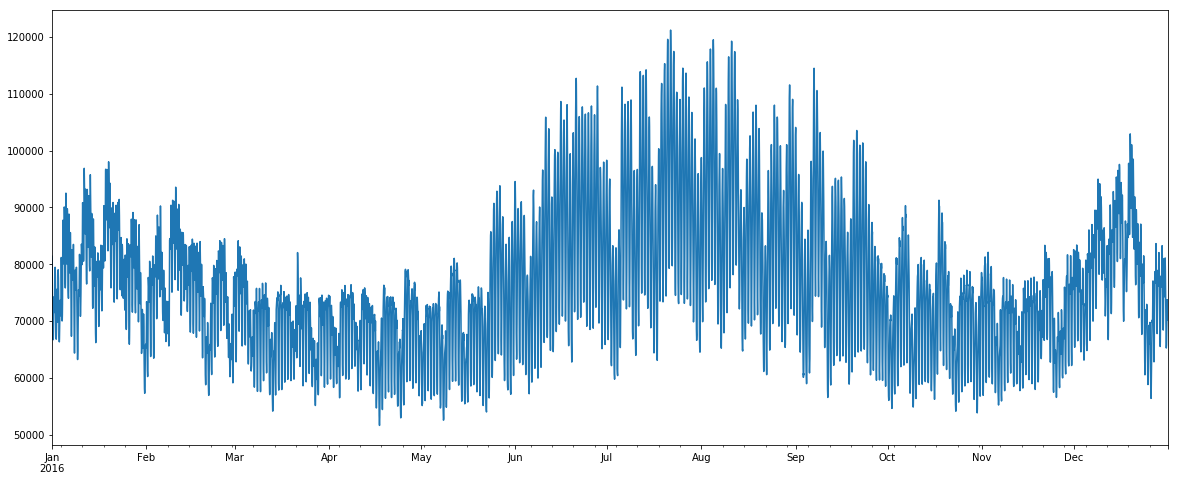

In [111]:
demand_interpolated.MISO.plot(figsize = (20,8))
demand_interpolated.columns

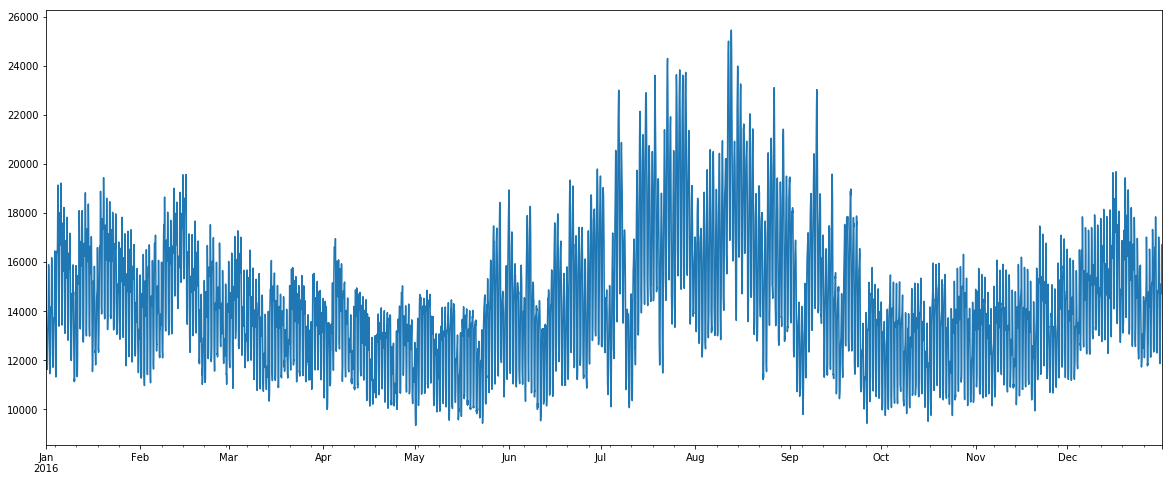

In [112]:
demand_interpolated.ISNE.plot(figsize = (20,8))

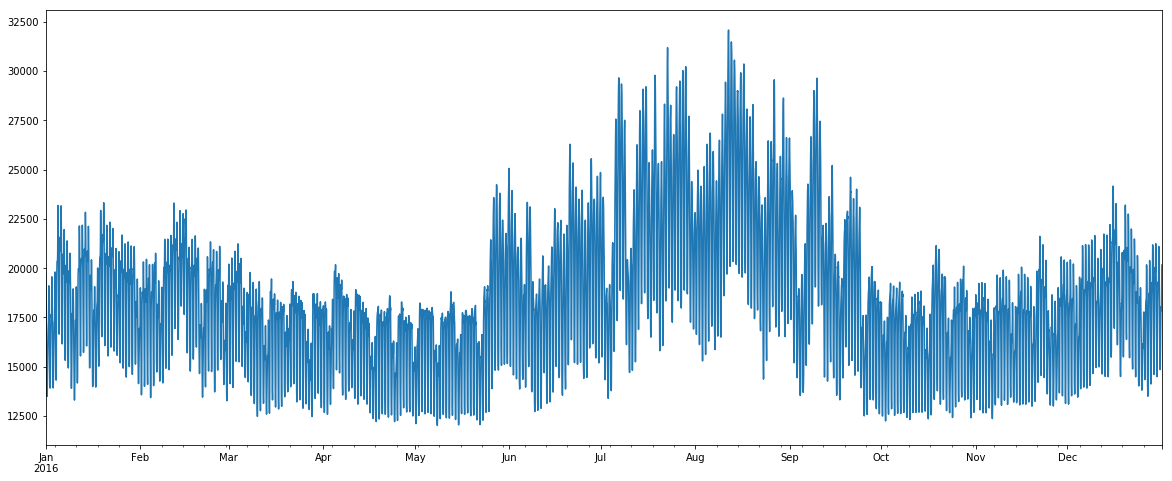

In [113]:
demand_interpolated.NYIS.plot(figsize = (20,8))

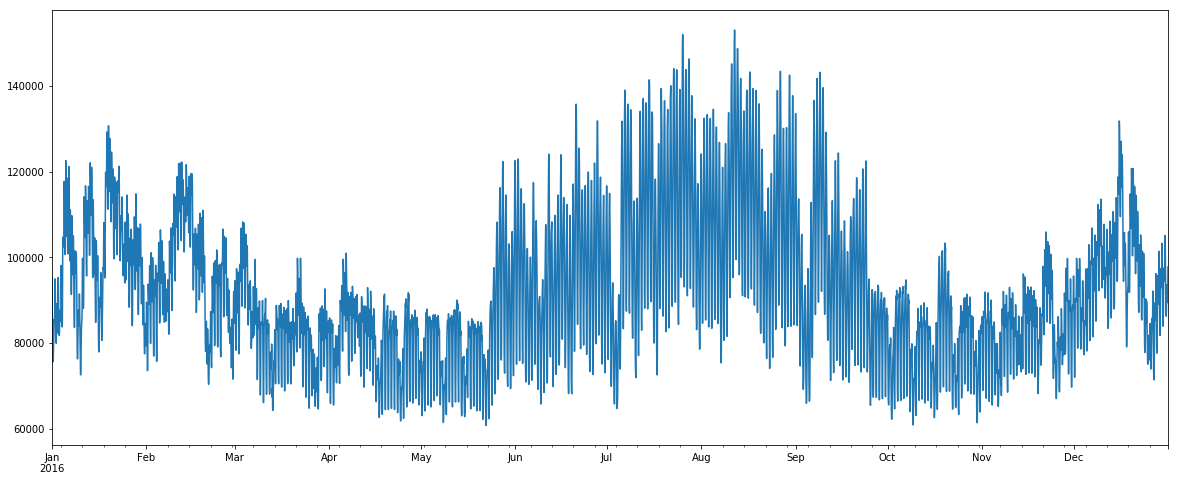

In [114]:
demand_interpolated.PJM.plot(figsize = (20,8))

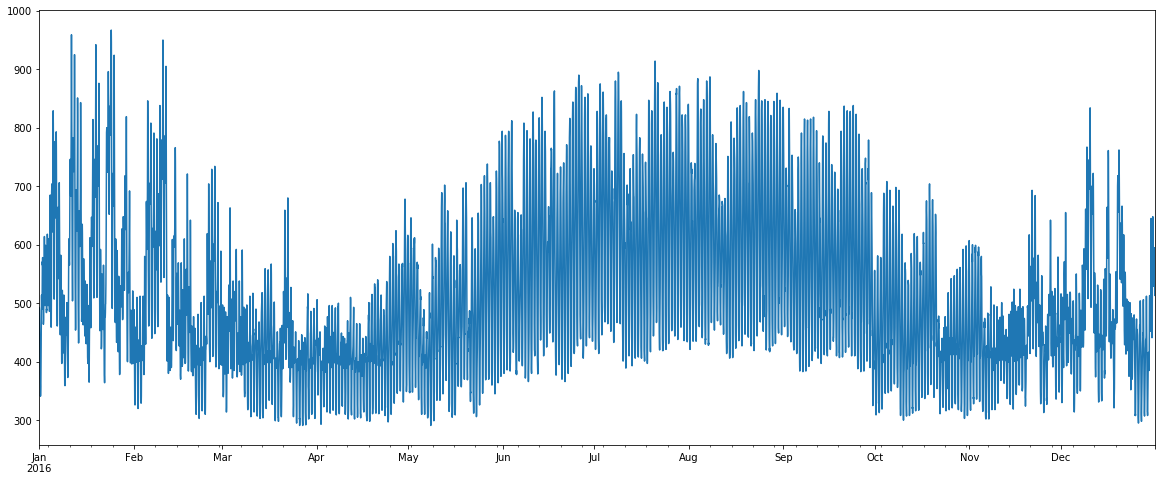

In [115]:
demand_interpolated.AEC.plot(figsize = (20,8))

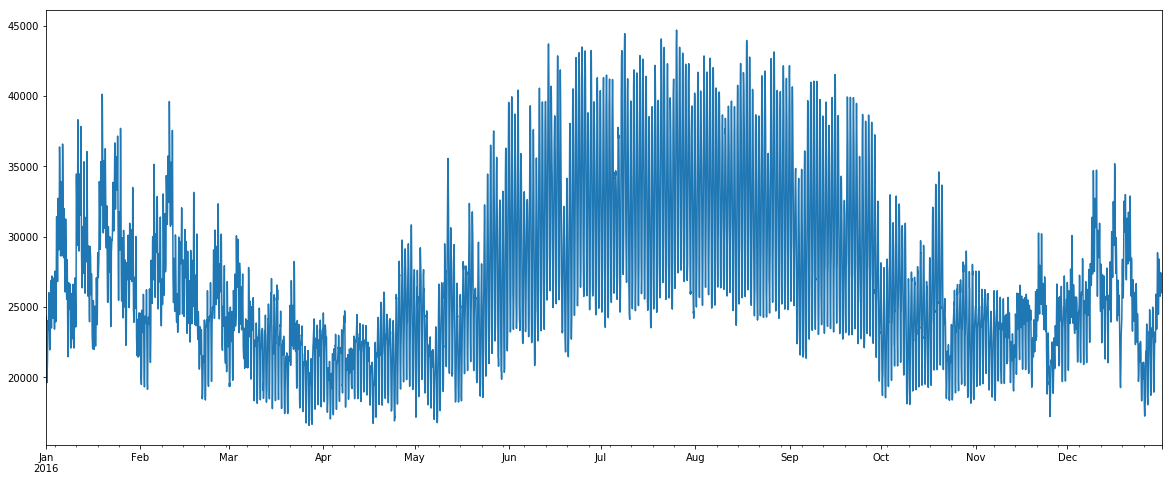

In [116]:
demand_interpolated.SOCO.plot(figsize = (20,8))

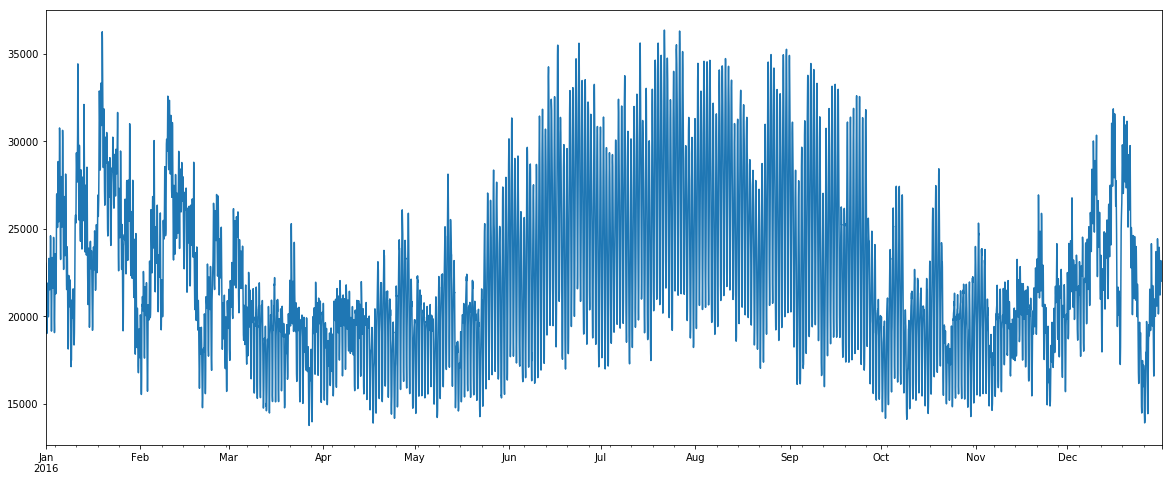

In [117]:
demand_interpolated.TVA_LGEE.plot(figsize = (20,8))

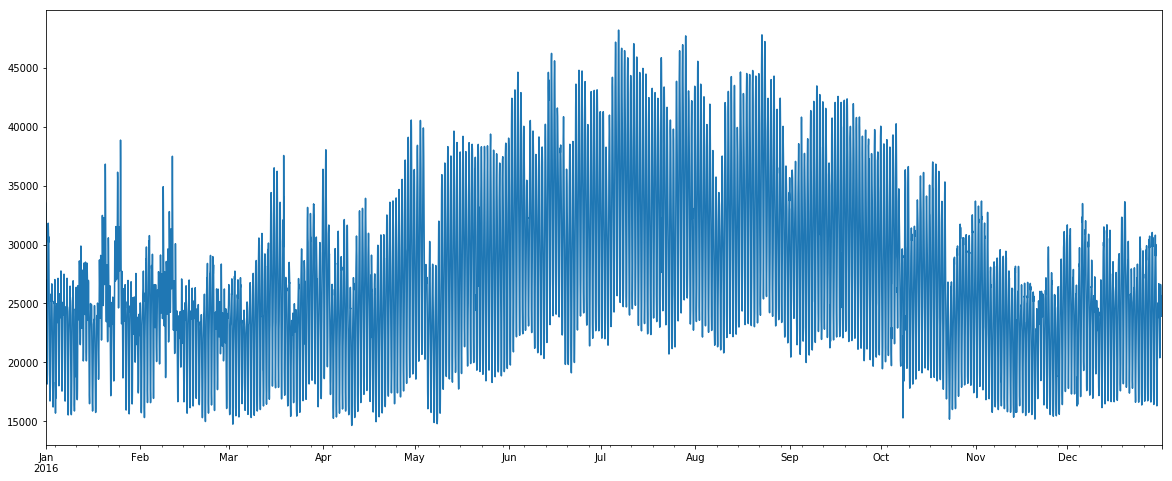

In [118]:
demand_interpolated.Florida.plot(figsize = (20,8))

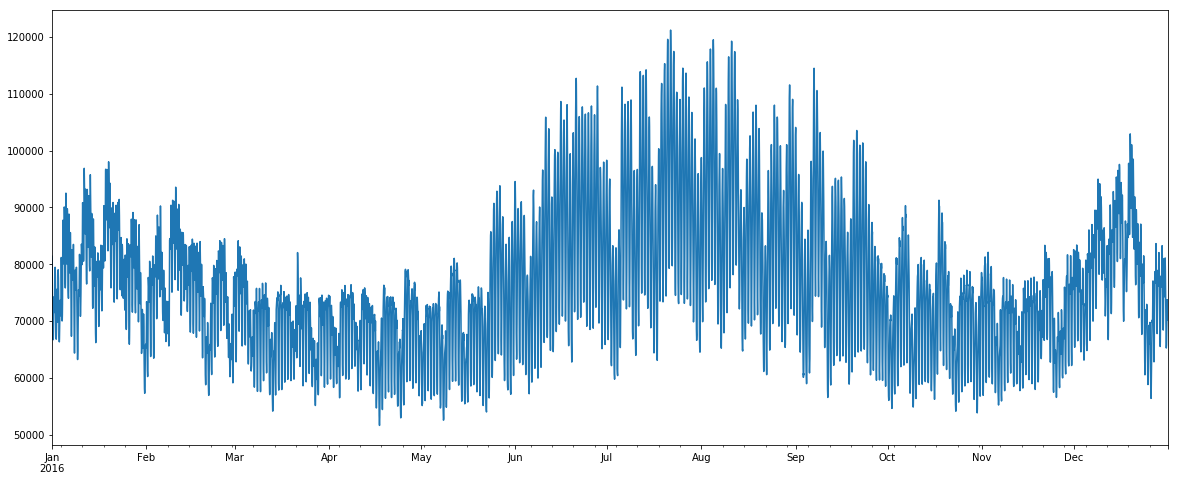

In [119]:
demand_interpolated.MISO.plot(figsize = (20,8))

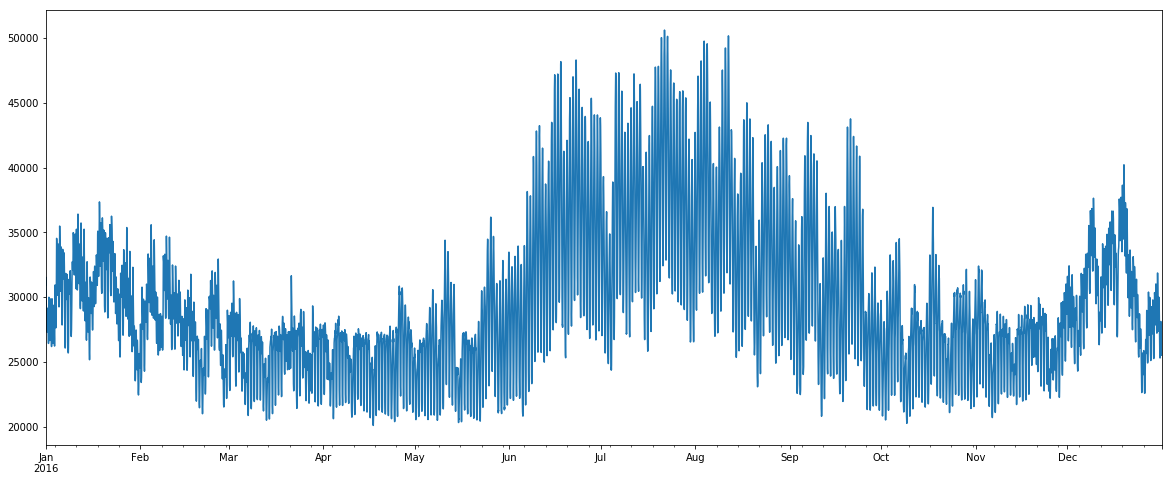

In [120]:
demand_interpolated.SWPP.plot(figsize = (20,8))

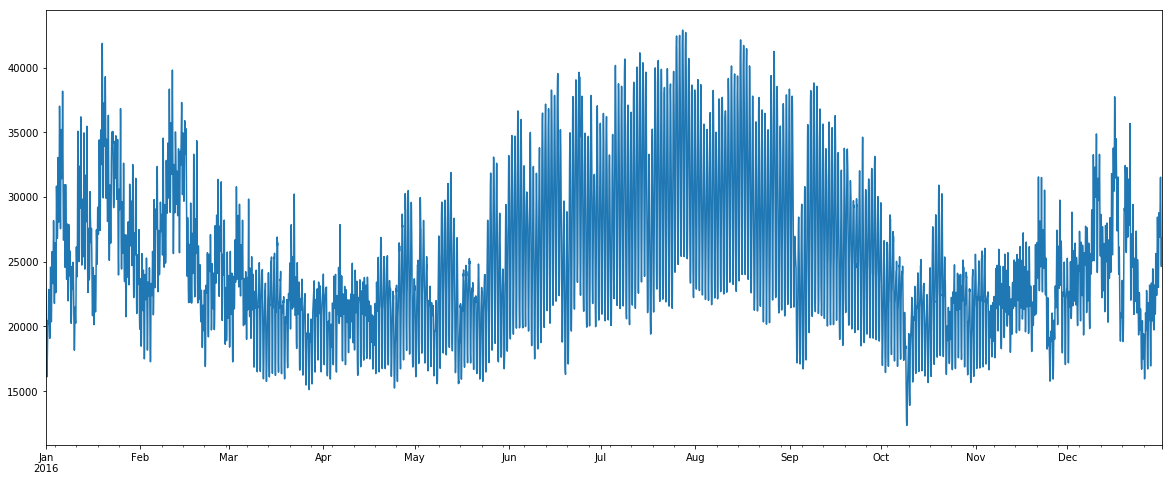

In [121]:
demand_interpolated.Carolina.plot(figsize = (20,8))

In [54]:
df = pickle.load(open('eastern_agg_demand.pkl', 'rb'))

In [55]:
df.columns

Index(['ISNE', 'NYIS', 'PJM', 'AEC', 'SOCO', 'TVA_LGEE', 'Florida', 'MISO',
       'SWPP', 'Carolina'],
      dtype='object')

In [57]:
df.isna().sum() #no blanks

ISNE        0
NYIS        0
PJM         0
AEC         0
SOCO        0
TVA_LGEE    0
Florida     0
MISO        0
SWPP        0
Carolina    0
dtype: int64

In [76]:
df_all.isna().sum()

NameError: name 'df_all' is not defined

In [9]:
import numpy as np





def slope_interpolate(ba_df):

    """Look for demand outliers by applying a z-score threshold to the demand

        slope. Loop through all the outliers detected, determine the non-outlier

        edge points and then interpolate a line joining these 2 edge points. The

        line value at the timestamp of the the outlier event is used to replace

        the anomalous value.



    :param pandas.DataFrame ba_df: demand data frame with UTC time as index and
        BA name as column name
    :return: (*pandas.DataFrame*) -- data frame indexed with hourly UTC time and
        with anomalous demand values replaced by interpolated values.



    .. note::

        It is implicitly assumed that:



        1. demand is correlated with temperature, and temperature rise is

        limited by heat capacity which is finite and generally uniform across

        region; hence, temperature dependent derivative spikes are unphysical.



        2. there is indeed nothing anomalous that happened to electrical usage

        in the relevant time range, so using a line to estimate the correct

        value is reasonable.





    .. todo::

        If there are more than a few hours (say > 4) of anomalous behavior,

        linear interpolation may give a bad estimate. Non-linear interpolation

        methods should be considered, and other information may be needed to

        interpolate properly, for example, the temperature data or other

        relevant profiles.

    """



    df = ba_df.copy()

    ba_name = df.columns[0]



    df['delta'] = df[ba_name].diff()

    delta_mu = df['delta'].describe().loc['mean']

    delta_sigma = df['delta'].describe().loc['std']

    df['delta_zscore'] = np.abs((df['delta'] - delta_mu)/delta_sigma)



    # Find the outliers

    outlier_index_list = df.loc[df['delta_zscore'] > 5].index



    hour_save = -1

    for i in outlier_index_list:

        hour_index = df.index.get_loc(i)

        if hour_save == -1:

            hour_save = hour_index

            next_save = hour_index + 1

            continue

        if hour_index == next_save:

            next_save = hour_index + 1

            continue



        # Check for zeros: consecutive zeros, which don't have delta_zscore

        # exceed threshold, will get extrapolated to the next non-zero value.

        # This is fine for, say up to 5 hours; will not be appropriate

        # otherwise since it may not capture the periodic patterns.

        # Print a warning



        if df.iloc[hour_index-1][ba_name] == 0:

            # print(hour_index, '->', next_save)

            next_save = hour_index + 1

            continue



        num = next_save - hour_save



        if num > 5:

            print('Too many zeros near ', i, '! Review data!')



        start = df.iloc[hour_save-1][ba_name]

        dee = (df.iloc[next_save-1][ba_name] - start)/num

        for j in range(hour_save-1, next_save):

            save_me = df.iloc[j][ba_name]

            df.iloc[j][ba_name] = start + (j - hour_save + 1)*dee

            print(j, save_me, df.iloc[j][ba_name])

        hour_save = hour_index

        next_save = hour_index + 1



    if hour_save != -1:

        num = next_save - hour_save

        start = df.iloc[hour_save-1][ba_name]

        dee = (df.iloc[next_save-1][ba_name] - start)/num

        for j in range(hour_save-1, next_save):

            save_me = df.iloc[j][ba_name]

            df.iloc[j][ba_name] = start + (j - hour_save + 1)*dee

            print(j, save_me, df.iloc[j][ba_name])



    return df

In [65]:
print('ISNE')
df_ISNE = slope_interpolate(df.iloc[:,0:1]) 
print('NYIS')
df_NYIS = slope_interpolate(df.iloc[:,1:2]) 
print('PJM')
df_PJM = slope_interpolate(df.iloc[:,2:3]) 
print('AEC')
df_AEC = slope_interpolate(df.iloc[:,3:4]) 
print('SOCO')
df_SOCO = slope_interpolate(df.iloc[:,4:5]) 
print('TVA_LGEE')
df_TVA_LGEE = slope_interpolate(df.iloc[:,5:6]) 
print('Florida')
df_Florida = slope_interpolate(df.iloc[:,6:7]) 
print('MISO')
df_MISO = slope_interpolate(df.iloc[:,7:8]) 
print('SWPP')
df_SWPP = slope_interpolate(df.iloc[:,8:9]) 
print('Carolina')
df_Carolina = slope_interpolate(df.iloc[:,9:10])


ISNE
NYIS
PJM
1357 104873.0 104873.0
1358 137033.0 104409.0
1359 103945.0 103945.0
AEC
SOCO
2410 19206.0 19206.0
2411 26343.0 19742.0
2412 20278.0 20278.0
TVA_LGEE
701 23378.0 23378.0
702 4517.0 22913.0
703 22448.0 22448.0
7469 16362.0 16362.0
7470 4106.0 15976.0
7471 15590.0 15590.0
8237 25897.0 25897.0
8238 5649.0 25647.5
8239 25398.0 25398.0
8477 28120.0 28120.0
8478 7081.0 27567.5
8479 27015.0 27015.0
Florida
1 31645.0 31645.0
2 22897.0 22897.0
1564 18918.0 18918.0
1565 28308.0 18278.0
1566 17638.0 17638.0
1876 31575.0 31575.0
1877 21080.0 21080.0
3412 33165.0 33165.0
3413 23562.0 23562.0
4850 38735.0 38735.0
4851 27638.0 27638.0
6094 42074.0 42074.0
6095 30860.0 30860.0
6171 30200.0 30200.0
6172 21228.0 21228.0
6266 34131.0 34131.0
6267 24657.0 24657.0
6746 26350.0 26350.0
6747 15276.0 15276.0
7195 30944.0 30944.0
7196 41548.0 31338.5
7197 31733.0 31733.0
7633 27013.0 27013.0
7634 15766.0 15766.0
MISO
SWPP
Carolina
3134 23557.0 23557.0
3135 33833.0 24623.5
3136 25690.0 25690.0
420

In [24]:
df_PJM.plot()

C:\Users\vhunt\AppData\Roaming\Python\Python37\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [60]:
df_NYIS

,NYIS,delta,delta_zscore
2016-01-01 00:00:00+00:00,19726.0,NaN,NaN
2016-01-01 01:00:00+00:00,19008.0,-718.0,0.951560
2016-01-01 02:00:00+00:00,18340.0,-668.0,0.885300
2016-01-01 03:00:00+00:00,17557.0,-783.0,1.037699
2016-01-01 04:00:00+00:00,16772.0,-785.0,1.040349
...,...,...,...
2016-12-31 19:00:00+00:00,17863.0,-109.0,0.144512
2016-12-31 20:00:00+00:00,17847.0,-16.0,0.021269
2016-12-31 21:00:00+00:00,18117.0,270.0,0.357739
2016-12-31 22:00:00+00:00,19122.0,1005.0,1.331763


In [19]:
df.columns


Index(['ISNE', 'NYIS', 'PJM', 'AEC', 'SOCO', 'TVA_LGEE', 'Florida', 'MISO',
       'SWPP', 'Carolina'],
      dtype='object')

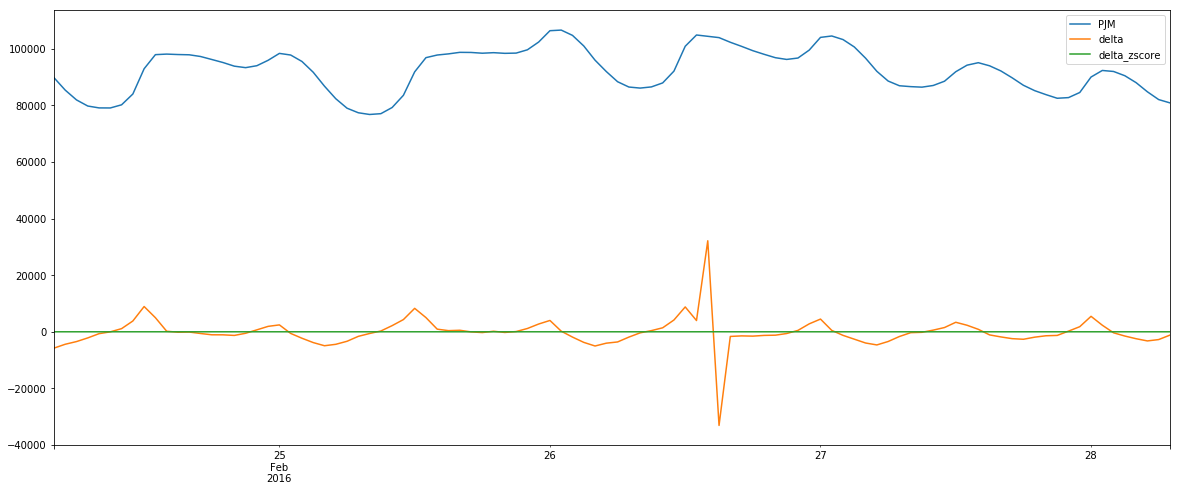

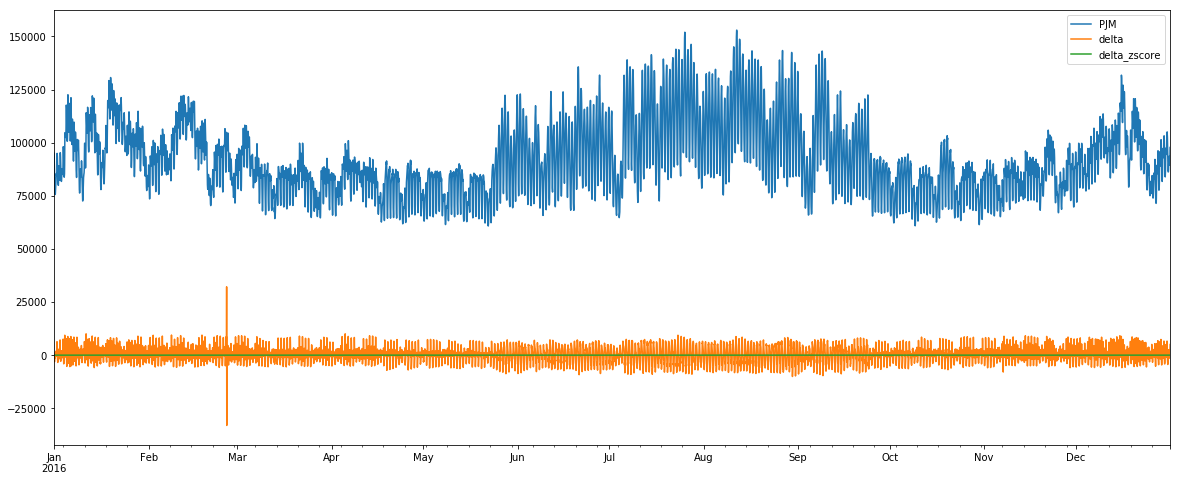

In [32]:
%matplotlib inline
df_PJM.iloc[1300:1400,].plot(figsize=[20,8])
df_PJM.plot(figsize=[20,8])
#df.PJM.plot(figsize=[20,8]) #looks good

In [66]:
df_ISNE.drop(['delta','delta_zscore'], axis=1, inplace=True)
df_NYIS.drop(['delta','delta_zscore'], axis=1, inplace=True)
df_PJM.drop(['delta','delta_zscore'], axis=1, inplace=True)
df_AEC.drop(['delta','delta_zscore'], axis=1, inplace=True)
df_SOCO.drop(['delta','delta_zscore'], axis=1, inplace=True)
df_TVA_LGEE.drop(['delta','delta_zscore'], axis=1, inplace=True)
df_Florida.drop(['delta','delta_zscore'], axis=1, inplace=True)
df_MISO.drop(['delta','delta_zscore'], axis=1, inplace=True)
df_SWPP.drop(['delta','delta_zscore'], axis=1, inplace=True)
df_Carolina.drop(['delta','delta_zscore'], axis=1, inplace=True)

In [67]:
frames = [df_ISNE, df_NYIS,df_PJM, df_AEC , df_SOCO, df_TVA_LGEE, df_Florida, df_MISO, df_SWPP, df_Carolina]
demand_interpolated = pd.concat(frames, axis = 1)

In [68]:
demand_interpolated

,ISNE,NYIS,PJM,AEC,SOCO,TVA_LGEE,Florida,MISO,SWPP,Carolina
2016-01-01 00:00:00+00:00,16063.0,19726.0,95072.0,492.0,23927.0,23022.0,33518.0,81398.0,30943.0,22878.0
2016-01-01 01:00:00+00:00,15273.0,19008.0,92298.0,488.0,24347.0,22800.0,31645.0,80848.0,31540.0,22097.0
2016-01-01 02:00:00+00:00,14568.0,18340.0,89416.0,465.0,23574.0,22258.0,22897.0,78731.0,31027.0,21357.0
2016-01-01 03:00:00+00:00,13850.0,17557.0,86496.0,444.0,22762.0,21679.0,26967.0,76741.0,30477.0,20466.0
2016-01-01 04:00:00+00:00,13108.0,16772.0,83405.0,429.0,21857.0,21099.0,25011.0,74748.0,29887.0,19469.0
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00+00:00,14716.0,17863.0,89450.0,545.0,26496.0,22763.0,23986.0,72137.0,26793.0,24925.0
2016-12-31 20:00:00+00:00,14714.0,17847.0,90143.0,528.0,26294.0,22446.0,23906.0,70783.0,26167.0,24653.0
2016-12-31 21:00:00+00:00,14965.0,18117.0,90906.0,513.0,26043.0,22009.0,23985.0,70195.0,25678.0,24634.0
2016-12-31 22:00:00+00:00,15996.0,19122.0,92752.0,521.0,26012.0,22136.0,24431.0,70239.0,25505.0,25303.0


In [73]:
with open('demand_interpolated.pkl', 'wb') as handle:
  pickle.dump(demand_interpolated, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#check miso


In [ ]:
df = pickle.load(open('eastern_agg_demand.pkl', 'rb'))

In [72]:
dffinal = pickle.load(open('demand_interpolated.pkl', 'rb'))
dffinal

,ISNE,NYIS,PJM,AEC,SOCO,TVA_LGEE,Florida,MISO,SWPP,Carolina
2016-01-01 00:00:00+00:00,16063.0,19726.0,95072.0,492.0,23927.0,23022.0,33518.0,81398.0,30943.0,22878.0
2016-01-01 01:00:00+00:00,15273.0,19008.0,92298.0,488.0,24347.0,22800.0,31645.0,80848.0,31540.0,22097.0
2016-01-01 02:00:00+00:00,14568.0,18340.0,89416.0,465.0,23574.0,22258.0,22897.0,78731.0,31027.0,21357.0
2016-01-01 03:00:00+00:00,13850.0,17557.0,86496.0,444.0,22762.0,21679.0,26967.0,76741.0,30477.0,20466.0
2016-01-01 04:00:00+00:00,13108.0,16772.0,83405.0,429.0,21857.0,21099.0,25011.0,74748.0,29887.0,19469.0
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00+00:00,14716.0,17863.0,89450.0,545.0,26496.0,22763.0,23986.0,72137.0,26793.0,24925.0
2016-12-31 20:00:00+00:00,14714.0,17847.0,90143.0,528.0,26294.0,22446.0,23906.0,70783.0,26167.0,24653.0
2016-12-31 21:00:00+00:00,14965.0,18117.0,90906.0,513.0,26043.0,22009.0,23985.0,70195.0,25678.0,24634.0
2016-12-31 22:00:00+00:00,15996.0,19122.0,92752.0,521.0,26012.0,22136.0,24431.0,70239.0,25505.0,25303.0


In [83]:
eastern_ba = ['SWPP','MISO','AECI','SPA','EEI','LGEE','OVEC','PJM','NYIS','ISNE','TVA','CPLW','DUK','YAD','CPLE',\
            'AEC','SOCO','SEPA','SC','TAL','SCEG','GVL','JEA','SEC','FPC','NSB','TEC','FMPP','FPL','HST']

start = pd.to_datetime('2016-01-01 00:00:00')
end = pd.to_datetime('2016-12-31 23:00:00')

eastern_demand = get_BA_demand(eastern_ba, start, end, 'd826fe7862968708eb6a3c2639d6da1b')
eastern_demand_2016 = eastern_demand.loc[start:end]

EEI not found
YAD not found
SEPA not found


In [84]:
eastern_demand_2016.isna().sum()

SWPP       0
MISO      11
AECI       0
SPA        0
LGEE       0
OVEC    2938
PJM       26
NYIS       0
ISNE       3
TVA       23
CPLW      23
DUK        0
CPLE      23
AEC        0
SOCO     241
SC        25
TAL        0
SCEG       0
GVL        0
JEA        6
SEC       96
FPC       23
NSB      186
TEC        0
FMPP     258
FPL       35
HST      192
dtype: int64

In [85]:
look_back1day = eastern_demand_2016.shift(1, freq ='D') 
look_forward1day = eastern_demand_2016.shift(-1, freq ='D') 

In [86]:
df = pd.concat([eastern_demand_2016, look_back1day, look_forward1day ], axis = 1)

In [87]:
df.head()

,SWPP,MISO,AECI,SPA,LGEE,OVEC,PJM,NYIS,ISNE,TVA,...,SCEG,GVL,JEA,SEC,FPC,NSB,TEC,FMPP,FPL,HST
2015-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2637.0,270.0,NaN,175.0,7389.0,65.0,2969.0,2507.0,18036.0,84.0
2015-12-31 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2558.0,258.0,NaN,164.0,6931.0,61.0,2778.0,2386.0,16990.0,79.0
2015-12-31 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2487.0,244.0,NaN,152.0,0.0,53.0,2575.0,2226.0,15650.0,73.0
2015-12-31 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2374.0,229.0,NaN,140.0,5830.0,51.0,2397.0,2049.0,14406.0,66.0
2015-12-31 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2256.0,213.0,NaN,128.0,5405.0,48.0,2223.0,1908.0,13389.0,60.0


In [88]:
df.drop(df.head(24).index, inplace=True)
df.drop(df.tail(24).index, inplace=True)

In [89]:
df['dayofweek'] = df.index.dayofweek 

In [90]:
df.dayofweek

2016-01-01 00:00:00+00:00    4
2016-01-01 01:00:00+00:00    4
2016-01-01 02:00:00+00:00    4
2016-01-01 03:00:00+00:00    4
2016-01-01 04:00:00+00:00    4
                            ..
2016-12-31 19:00:00+00:00    5
2016-12-31 20:00:00+00:00    5
2016-12-31 21:00:00+00:00    5
2016-12-31 22:00:00+00:00    5
2016-12-31 23:00:00+00:00    5
Freq: H, Name: dayofweek, Length: 8784, dtype: int64

In [91]:
df[['dayofweek','MISO']]
#orig, look back one day, look forward one day

,dayofweek,MISO,MISO,MISO
2016-01-01 00:00:00+00:00,4,78481.0,NaN,75876.0
2016-01-01 01:00:00+00:00,4,77902.0,NaN,76569.0
2016-01-01 02:00:00+00:00,4,75821.0,NaN,75933.0
2016-01-01 03:00:00+00:00,4,73863.0,NaN,74786.0
2016-01-01 04:00:00+00:00,4,71919.0,NaN,73039.0
...,...,...,...,...
2016-12-31 19:00:00+00:00,5,69959.0,74411.0,NaN
2016-12-31 20:00:00+00:00,5,68689.0,73086.0,NaN
2016-12-31 21:00:00+00:00,5,68160.0,72123.0,NaN
2016-12-31 22:00:00+00:00,5,68204.0,72147.0,NaN


In [92]:
df_MISO = df[['dayofweek','MISO']]
df_MISO.columns = ['dayofweek','MISO','lookback','lookforward']
df_MISO['av'] = df_MISO[['lookback','lookforward']].mean(axis = 1)
df_MISO.av

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2016-01-01 00:00:00+00:00    75876.0
2016-01-01 01:00:00+00:00    76569.0
2016-01-01 02:00:00+00:00    75933.0
2016-01-01 03:00:00+00:00    74786.0
2016-01-01 04:00:00+00:00    73039.0
                              ...   
2016-12-31 19:00:00+00:00    74411.0
2016-12-31 20:00:00+00:00    73086.0
2016-12-31 21:00:00+00:00    72123.0
2016-12-31 22:00:00+00:00    72147.0
2016-12-31 23:00:00+00:00    74384.0
Freq: H, Name: av, Length: 8784, dtype: float64

In [93]:
df_MISO.loc[df_MISO["MISO"].isnull()]

,dayofweek,MISO,lookback,lookforward,av
2016-06-17 04:00:00+00:00,4,NaN,87417.0,84435.0,85926.0
2016-06-17 05:00:00+00:00,4,NaN,80879.0,78751.0,79815.0
2016-12-22 21:00:00+00:00,3,NaN,77621.0,73903.0,75762.0
2016-12-22 22:00:00+00:00,3,NaN,77585.0,74025.0,75805.0
2016-12-22 23:00:00+00:00,3,NaN,80078.0,76242.0,78160.0
2016-12-23 00:00:00+00:00,4,NaN,83931.0,78600.0,81265.5
2016-12-23 01:00:00+00:00,4,NaN,84207.0,77906.0,81056.5
2016-12-23 02:00:00+00:00,4,NaN,83221.0,76347.0,79784.0
2016-12-23 03:00:00+00:00,4,NaN,82007.0,74825.0,78416.0
2016-12-23 04:00:00+00:00,4,NaN,79232.0,71866.0,75549.0


In [94]:
df_MISO.loc[(df_MISO.dayofweek == 0)& (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.lookforward
df_MISO.loc[(df_MISO.dayofweek == 1)& (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.av
df_MISO.loc[(df_MISO.dayofweek == 2)& (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.av
df_MISO.loc[(df_MISO.dayofweek == 3)& (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.av
df_MISO.loc[(df_MISO.dayofweek == 4)& (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.lookback
df_MISO.loc[(df_MISO.dayofweek == 5)& (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.lookforward
df_MISO.loc[(df_MISO.dayofweek == 6)& (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.lookback

C:\Users\vhunt\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [95]:
df.columns[1]

'MISO'

In [15]:
eastern_demand_2016.isnull().sum(axis=0)
#MISO, PJM, ISNE, TVA,CPLW,CPLE,SOCO SC JEA SEC FPC NSB TEC FMPP FPL HST
list0 = eastern_demand_2016.isnull().sum(axis=0)
list0[list0 >0]

MISO      11
OVEC    2938
PJM       26
ISNE       3
TVA       23
CPLW      23
CPLE      23
SOCO     241
SC        25
JEA        6
SEC       96
FPC       23
NSB      186
FMPP     258
FPL       35
HST      192
dtype: int64

In [96]:
df_MISO = df[['dayofweek','MISO']]
df_MISO.columns = ['dayofweek','MISO','lookback','lookforward']
df_MISO['av'] = df_MISO[['lookback','lookforward']].mean(axis = 1)
df_MISO.loc[(df_MISO.dayofweek == 0) & (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.lookforward
df_MISO.loc[(df_MISO.dayofweek == 1) & (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.av
df_MISO.loc[(df_MISO.dayofweek == 2) & (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.av
df_MISO.loc[(df_MISO.dayofweek == 3) & (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.av
df_MISO.loc[(df_MISO.dayofweek == 4) & (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.lookback
df_MISO.loc[(df_MISO.dayofweek == 5) & (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.lookforward
df_MISO.loc[(df_MISO.dayofweek == 6) & (df_MISO.MISO.isna()) , 'MISO'] = df_MISO.lookback

df_PJM = df[['dayofweek','PJM']]
df_PJM.columns = ['dayofweek','PJM','lookback','lookforward']
df_PJM['av'] = df_PJM[['lookback','lookforward']].mean(axis = 1)
df_PJM.loc[(df_PJM.dayofweek == 0)& (df_PJM.PJM.isna()) , 'PJM'] = df_PJM.lookforward
df_PJM.loc[(df_PJM.dayofweek == 1)& (df_PJM.PJM.isna()) , 'PJM'] = df_PJM.av
df_PJM.loc[(df_PJM.dayofweek == 2)& (df_PJM.PJM.isna()) , 'PJM'] = df_PJM.av
df_PJM.loc[(df_PJM.dayofweek == 3)& (df_PJM.PJM.isna()) , 'PJM'] = df_PJM.av
df_PJM.loc[(df_PJM.dayofweek == 4)& (df_PJM.PJM.isna()) , 'PJM'] = df_PJM.lookback
df_PJM.loc[(df_PJM.dayofweek == 5)& (df_PJM.PJM.isna()) , 'PJM'] = df_PJM.lookforward
df_PJM.loc[(df_PJM.dayofweek == 6)& (df_PJM.PJM.isna()) , 'PJM'] = df_PJM.lookback

df_ISNE = df[['dayofweek','ISNE']]
df_ISNE.columns = ['dayofweek','ISNE','lookback','lookforward']
df_ISNE['av'] = df_ISNE[['lookback','lookforward']].mean(axis = 1)
df_ISNE.loc[(df_ISNE.dayofweek == 0)& (df_ISNE.ISNE.isna()) , 'ISNE'] = df_ISNE.lookforward
df_ISNE.loc[(df_ISNE.dayofweek == 1)& (df_ISNE.ISNE.isna()) , 'ISNE'] = df_ISNE.av
df_ISNE.loc[(df_ISNE.dayofweek == 2)& (df_ISNE.ISNE.isna()) , 'ISNE'] = df_ISNE.av
df_ISNE.loc[(df_ISNE.dayofweek == 3)& (df_ISNE.ISNE.isna()) , 'ISNE'] = df_ISNE.av
df_ISNE.loc[(df_ISNE.dayofweek == 4)& (df_ISNE.ISNE.isna()) , 'ISNE'] = df_ISNE.lookback
df_ISNE.loc[(df_ISNE.dayofweek == 5)& (df_ISNE.ISNE.isna()) , 'ISNE'] = df_ISNE.lookforward
df_ISNE.loc[(df_ISNE.dayofweek == 6)& (df_ISNE.ISNE.isna()) , 'ISNE'] = df_ISNE.lookback

df_TVA = df[['dayofweek','TVA']]
df_TVA.columns = ['dayofweek','TVA','lookback','lookforward']
df_TVA['av'] = df_TVA[['lookback','lookforward']].mean(axis = 1)
df_TVA.loc[(df_TVA.dayofweek == 0)& (df_TVA.TVA.isna()) , 'TVA'] = df_TVA.lookforward
df_TVA.loc[(df_TVA.dayofweek == 1)& (df_TVA.TVA.isna()) , 'TVA'] = df_TVA.av
df_TVA.loc[(df_TVA.dayofweek == 2)& (df_TVA.TVA.isna()) , 'TVA'] = df_TVA.av
df_TVA.loc[(df_TVA.dayofweek == 3)& (df_TVA.TVA.isna()) , 'TVA'] = df_TVA.av
df_TVA.loc[(df_TVA.dayofweek == 4)& (df_TVA.TVA.isna()) , 'TVA'] = df_TVA.lookback
df_TVA.loc[(df_TVA.dayofweek == 5)& (df_TVA.TVA.isna()) , 'TVA'] = df_TVA.lookforward
df_TVA.loc[(df_TVA.dayofweek == 6)& (df_TVA.TVA.isna()) , 'TVA'] = df_TVA.lookback

df_CPLW = df[['dayofweek','CPLW']]
df_CPLW.columns = ['dayofweek','CPLW','lookback','lookforward']
df_CPLW['av'] = df_CPLW[['lookback','lookforward']].mean(axis = 1)
df_CPLW.loc[(df_CPLW.dayofweek == 0)& (df_CPLW.CPLW.isna()) , 'CPLW'] = df_CPLW.lookforward
df_CPLW.loc[(df_CPLW.dayofweek == 1)& (df_CPLW.CPLW.isna()) , 'CPLW'] = df_CPLW.av
df_CPLW.loc[(df_CPLW.dayofweek == 2)& (df_CPLW.CPLW.isna()) , 'CPLW'] = df_CPLW.av
df_CPLW.loc[(df_CPLW.dayofweek == 3)& (df_CPLW.CPLW.isna()) , 'CPLW'] = df_CPLW.av
df_CPLW.loc[(df_CPLW.dayofweek == 4)& (df_CPLW.CPLW.isna()) , 'CPLW'] = df_CPLW.lookback
df_CPLW.loc[(df_CPLW.dayofweek == 5)& (df_CPLW.CPLW.isna()) , 'CPLW'] = df_CPLW.lookforward
df_CPLW.loc[(df_CPLW.dayofweek == 6)& (df_CPLW.CPLW.isna()) , 'CPLW'] = df_CPLW.lookback

df_CPLE = df[['dayofweek','CPLE']]
df_CPLE.columns = ['dayofweek','CPLE','lookback','lookforward']
df_CPLE['av'] = df_CPLE[['lookback','lookforward']].mean(axis = 1)
df_CPLE.loc[(df_CPLE.dayofweek == 0)& (df_CPLE.CPLE.isna()) , 'CPLE'] = df_CPLE.lookforward
df_CPLE.loc[(df_CPLE.dayofweek == 1)& (df_CPLE.CPLE.isna()) , 'CPLE'] = df_CPLE.av
df_CPLE.loc[(df_CPLE.dayofweek == 2)& (df_CPLE.CPLE.isna()) , 'CPLE'] = df_CPLE.av
df_CPLE.loc[(df_CPLE.dayofweek == 3)& (df_CPLE.CPLE.isna()) , 'CPLE'] = df_CPLE.av
df_CPLE.loc[(df_CPLE.dayofweek == 4)& (df_CPLE.CPLE.isna()) , 'CPLE'] = df_CPLE.lookback
df_CPLE.loc[(df_CPLE.dayofweek == 5)& (df_CPLE.CPLE.isna()) , 'CPLE'] = df_CPLE.lookforward
df_CPLE.loc[(df_CPLE.dayofweek == 6)& (df_CPLE.CPLE.isna()) , 'CPLE'] = df_CPLE.lookback

df_SOCO = df[['dayofweek','SOCO']]
df_SOCO.columns = ['dayofweek','SOCO','lookback','lookforward']
df_SOCO['av'] = df_SOCO[['lookback','lookforward']].mean(axis = 1)
df_SOCO.loc[(df_SOCO.dayofweek == 0)& (df_SOCO.SOCO.isna()) , 'SOCO'] = df_SOCO.lookforward
df_SOCO.loc[(df_SOCO.dayofweek == 1)& (df_SOCO.SOCO.isna()) , 'SOCO'] = df_SOCO.av
df_SOCO.loc[(df_SOCO.dayofweek == 2)& (df_SOCO.SOCO.isna()) , 'SOCO'] = df_SOCO.av
df_SOCO.loc[(df_SOCO.dayofweek == 3)& (df_SOCO.SOCO.isna()) , 'SOCO'] = df_SOCO.av
df_SOCO.loc[(df_SOCO.dayofweek == 4)& (df_SOCO.SOCO.isna()) , 'SOCO'] = df_SOCO.lookback
df_SOCO.loc[(df_SOCO.dayofweek == 5)& (df_SOCO.SOCO.isna()) , 'SOCO'] = df_SOCO.lookforward
df_SOCO.loc[(df_SOCO.dayofweek == 6)& (df_SOCO.SOCO.isna()) , 'SOCO'] = df_SOCO.lookback

df_SC = df[['dayofweek','SC']]
df_SC.columns = ['dayofweek','SC','lookback','lookforward']
df_SC['av'] = df_SC[['lookback','lookforward']].mean(axis = 1)
df_SC.loc[(df_SC.dayofweek == 0)& (df_SC.SC.isna()) , 'SC'] = df_SC.lookforward
df_SC.loc[(df_SC.dayofweek == 1)& (df_SC.SC.isna()) , 'SC'] = df_SC.av
df_SC.loc[(df_SC.dayofweek == 2)& (df_SC.SC.isna()) , 'SC'] = df_SC.av
df_SC.loc[(df_SC.dayofweek == 3)& (df_SC.SC.isna()) , 'SC'] = df_SC.av
df_SC.loc[(df_SC.dayofweek == 4)& (df_SC.SC.isna()) , 'SC'] = df_SC.lookback
df_SC.loc[(df_SC.dayofweek == 5)& (df_SC.SC.isna()) , 'SC'] = df_SC.lookforward
df_SC.loc[(df_SC.dayofweek == 6)& (df_SC.SC.isna()) , 'SC'] = df_SC.lookback

df_JEA = df[['dayofweek','JEA']]
df_JEA.columns = ['dayofweek','JEA','lookback','lookforward']
df_JEA['av'] = df_JEA[['lookback','lookforward']].mean(axis = 1)
df_JEA.loc[(df_JEA.dayofweek == 0)& (df_JEA.JEA.isna()) , 'JEA'] = df_JEA.lookforward
df_JEA.loc[(df_JEA.dayofweek == 1)& (df_JEA.JEA.isna()) , 'JEA'] = df_JEA.av
df_JEA.loc[(df_JEA.dayofweek == 2)& (df_JEA.JEA.isna()) , 'JEA'] = df_JEA.av
df_JEA.loc[(df_JEA.dayofweek == 3)& (df_JEA.JEA.isna()) , 'JEA'] = df_JEA.av
df_JEA.loc[(df_JEA.dayofweek == 4)& (df_JEA.JEA.isna()) , 'JEA'] = df_JEA.lookback
df_JEA.loc[(df_JEA.dayofweek == 5)& (df_JEA.JEA.isna()) , 'JEA'] = df_JEA.lookforward
df_JEA.loc[(df_JEA.dayofweek == 6)& (df_JEA.JEA.isna()) , 'JEA'] = df_JEA.lookback

df_SEC = df[['dayofweek','SEC']]
df_SEC.columns = ['dayofweek','SEC','lookback','lookforward']
df_SEC['av'] = df_SEC[['lookback','lookforward']].mean(axis = 1)
df_SEC.loc[(df_SEC.dayofweek == 0)& (df_SEC.SEC.isna()) , 'SEC'] = df_SEC.lookforward
df_SEC.loc[(df_SEC.dayofweek == 1)& (df_SEC.SEC.isna()) , 'SEC'] = df_SEC.av
df_SEC.loc[(df_SEC.dayofweek == 2)& (df_SEC.SEC.isna()) , 'SEC'] = df_SEC.av
df_SEC.loc[(df_SEC.dayofweek == 3)& (df_SEC.SEC.isna()) , 'SEC'] = df_SEC.av
df_SEC.loc[(df_SEC.dayofweek == 4)& (df_SEC.SEC.isna()) , 'SEC'] = df_SEC.lookback
df_SEC.loc[(df_SEC.dayofweek == 5)& (df_SEC.SEC.isna()) , 'SEC'] = df_SEC.lookforward
df_SEC.loc[(df_SEC.dayofweek == 6)& (df_SEC.SEC.isna()) , 'SEC'] = df_SEC.lookback

df_FPC = df[['dayofweek','FPC']]
df_FPC.columns = ['dayofweek','FPC','lookback','lookforward']
df_FPC['av'] = df_FPC[['lookback','lookforward']].mean(axis = 1)
df_FPC.loc[(df_FPC.dayofweek == 0)& (df_FPC.FPC.isna()) , 'FPC'] = df_FPC.lookforward
df_FPC.loc[(df_FPC.dayofweek == 1)& (df_FPC.FPC.isna()) , 'FPC'] = df_FPC.av
df_FPC.loc[(df_FPC.dayofweek == 2)& (df_FPC.FPC.isna()) , 'FPC'] = df_FPC.av
df_FPC.loc[(df_FPC.dayofweek == 3)& (df_FPC.FPC.isna()) , 'FPC'] = df_FPC.av
df_FPC.loc[(df_FPC.dayofweek == 4)& (df_FPC.FPC.isna()) , 'FPC'] = df_FPC.lookback
df_FPC.loc[(df_FPC.dayofweek == 5)& (df_FPC.FPC.isna()) , 'FPC'] = df_FPC.lookforward
df_FPC.loc[(df_FPC.dayofweek == 6)& (df_FPC.FPC.isna()) , 'FPC'] = df_FPC.lookback


df_NSB = df[['dayofweek','NSB']]
df_NSB.columns = ['dayofweek','NSB','lookback','lookforward']
df_NSB['av'] = df_NSB[['lookback','lookforward']].mean(axis = 1)
df_NSB.loc[(df_NSB.dayofweek == 0)& (df_NSB.NSB.isna()) , 'NSB'] = df_NSB.lookforward
df_NSB.loc[(df_NSB.dayofweek == 1)& (df_NSB.NSB.isna()) , 'NSB'] = df_NSB.av
df_NSB.loc[(df_NSB.dayofweek == 2)& (df_NSB.NSB.isna()) , 'NSB'] = df_NSB.av
df_NSB.loc[(df_NSB.dayofweek == 3)& (df_NSB.NSB.isna()) , 'NSB'] = df_NSB.av
df_NSB.loc[(df_NSB.dayofweek == 4)& (df_NSB.NSB.isna()) , 'NSB'] = df_NSB.lookback
df_NSB.loc[(df_NSB.dayofweek == 5)& (df_NSB.NSB.isna()) , 'NSB'] = df_NSB.lookforward
df_NSB.loc[(df_NSB.dayofweek == 6)& (df_NSB.NSB.isna()) , 'NSB'] = df_NSB.lookback



df_FMPP = df[['dayofweek','FMPP']]
df_FMPP.columns = ['dayofweek','FMPP','lookback','lookforward']
df_FMPP['av'] = df_FMPP[['lookback','lookforward']].mean(axis = 1)
df_FMPP.loc[(df_FMPP.dayofweek == 0)& (df_FMPP.FMPP.isna()) , 'FMPP'] = df_FMPP.lookforward
df_FMPP.loc[(df_FMPP.dayofweek == 1)& (df_FMPP.FMPP.isna()) , 'FMPP'] = df_FMPP.av
df_FMPP.loc[(df_FMPP.dayofweek == 2)& (df_FMPP.FMPP.isna()) , 'FMPP'] = df_FMPP.av
df_FMPP.loc[(df_FMPP.dayofweek == 3)& (df_FMPP.FMPP.isna()) , 'FMPP'] = df_FMPP.av
df_FMPP.loc[(df_FMPP.dayofweek == 4)& (df_FMPP.FMPP.isna()) , 'FMPP'] = df_FMPP.lookback
df_FMPP.loc[(df_FMPP.dayofweek == 5)& (df_FMPP.FMPP.isna()) , 'FMPP'] = df_FMPP.lookforward
df_FMPP.loc[(df_FMPP.dayofweek == 6)& (df_FMPP.FMPP.isna()) , 'FMPP'] = df_FMPP.lookback


df_FPL = df[['dayofweek','FPL']]
df_FPL.columns = ['dayofweek','FPL','lookback','lookforward']
df_FPL['av'] = df_FPL[['lookback','lookforward']].mean(axis = 1)
df_FPL.loc[(df_FPL.dayofweek == 0)& (df_FPL.FPL.isna()) , 'FPL'] = df_FPL.lookforward
df_FPL.loc[(df_FPL.dayofweek == 1)& (df_FPL.FPL.isna()) , 'FPL'] = df_FPL.av
df_FPL.loc[(df_FPL.dayofweek == 2)& (df_FPL.FPL.isna()) , 'FPL'] = df_FPL.av
df_FPL.loc[(df_FPL.dayofweek == 3)& (df_FPL.FPL.isna()) , 'FPL'] = df_FPL.av
df_FPL.loc[(df_FPL.dayofweek == 4)& (df_FPL.FPL.isna()) , 'FPL'] = df_FPL.lookback
df_FPL.loc[(df_FPL.dayofweek == 5)& (df_FPL.FPL.isna()) , 'FPL'] = df_FPL.lookforward
df_FPL.loc[(df_FPL.dayofweek == 6)& (df_FPL.FPL.isna()) , 'FPL'] = df_FPL.lookback

df_HST = df[['dayofweek','HST']]
df_HST.columns = ['dayofweek','HST','lookback','lookforward']
df_HST['av'] = df_HST[['lookback','lookforward']].mean(axis = 1)
df_HST.loc[(df_HST.dayofweek == 0)& (df_HST.HST.isna()) , 'HST'] = df_HST.lookforward
df_HST.loc[(df_HST.dayofweek == 1)& (df_HST.HST.isna()) , 'HST'] = df_HST.av
df_HST.loc[(df_HST.dayofweek == 2)& (df_HST.HST.isna()) , 'HST'] = df_HST.av
df_HST.loc[(df_HST.dayofweek == 3)& (df_HST.HST.isna()) , 'HST'] = df_HST.av
df_HST.loc[(df_HST.dayofweek == 4)& (df_HST.HST.isna()) , 'HST'] = df_HST.lookback
df_HST.loc[(df_HST.dayofweek == 5)& (df_HST.HST.isna()) , 'HST'] = df_HST.lookforward
df_HST.loc[(df_HST.dayofweek == 6)& (df_HST.HST.isna()) , 'HST'] = df_HST.lookback


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [97]:

print("MISO", df_MISO.loc[df_MISO["MISO"].isnull()].shape[0])
print("PJM", df_PJM.loc[df_PJM["PJM"].isnull()].shape[0])
print("ISNE", df_ISNE.loc[df_ISNE["ISNE"].isnull()].shape[0])
print("TVA", df_TVA.loc[df_TVA["TVA"].isnull()].shape[0])
print("CPLW", df_CPLW.loc[df_CPLW["CPLW"].isnull()].shape[0])
print("CPLE", df_CPLE.loc[df_CPLE["CPLE"].isnull()].shape[0])
print("SOCO", df_SOCO.loc[df_SOCO["SOCO"].isnull()].shape[0])#190 problems!
print("SC", df_SC.loc[df_SC["SC"].isnull()].shape[0])
print("JEA", df_JEA.loc[df_JEA["JEA"].isnull()].shape[0])
print("SEC", df_SEC.loc[df_SEC["SEC"].isnull()].shape[0])
print("FPC", df_FPC.loc[df_FPC["FPC"].isnull()].shape[0])
print("NSB", df_NSB.loc[df_NSB["NSB"].isnull()].shape[0])
print("FMPP", df_FMPP.loc[df_FMPP["FMPP"].isnull()].shape[0])
print("FPL", df_FPL.loc[df_FPL["FPL"].isnull()].shape[0])
print("HST", df_HST.loc[df_HST["HST"].isnull()].shape[0]) #48

MISO 0
PJM 0
ISNE 0
TVA 0
CPLW 0
CPLE 0
SOCO 190
SC 0
JEA 6
SEC 36
FPC 0
NSB 30
FMPP 29
FPL 0
HST 48


C:\Users\vhunt\AppData\Roaming\Python\Python37\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


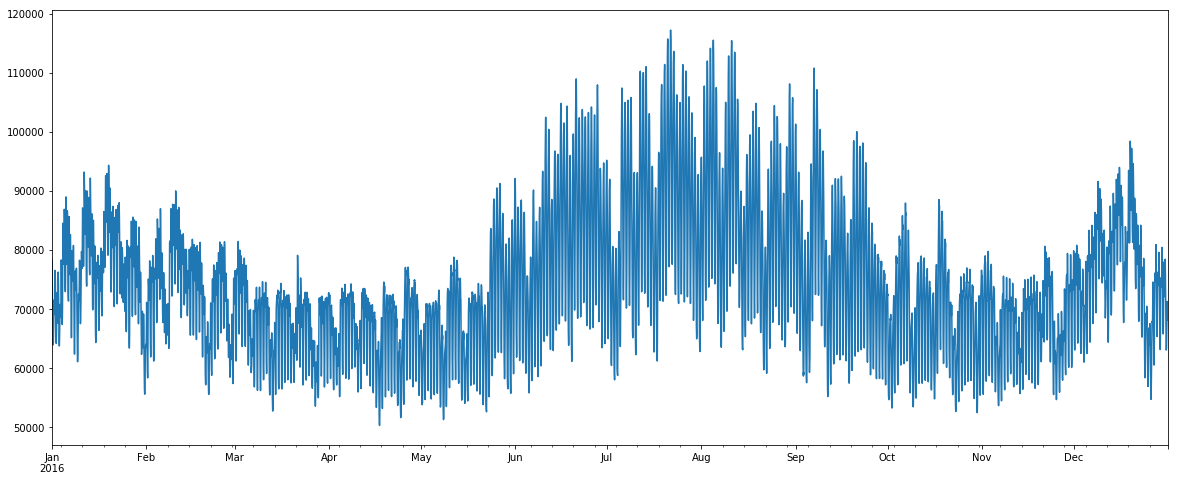

In [18]:
%matplotlib inline
df_MISO.MISO.plot(figsize=[20,8]) #no obvious outliers but will look season by season

In [102]:
sumcol = pd.concat([df_MISO, df['AECI']], axis = 1)
sumcol['sum'] = sumcol['MISO'] + sumcol['AECI']

TypeError: '<' not supported between instances of 'Timestamp' and 'str'

In [100]:
df_MISO

,dayofweek,MISO,lookback,lookforward,av
2016-01-01 00:00:00+00:00,4,78481.0,NaN,75876.0,75876.0
2016-01-01 01:00:00+00:00,4,77902.0,NaN,76569.0,76569.0
2016-01-01 02:00:00+00:00,4,75821.0,NaN,75933.0,75933.0
2016-01-01 03:00:00+00:00,4,73863.0,NaN,74786.0,74786.0
2016-01-01 04:00:00+00:00,4,71919.0,NaN,73039.0,73039.0
...,...,...,...,...,...
2016-12-31 19:00:00+00:00,5,69959.0,74411.0,NaN,74411.0
2016-12-31 20:00:00+00:00,5,68689.0,73086.0,NaN,73086.0
2016-12-31 21:00:00+00:00,5,68160.0,72123.0,NaN,72123.0
2016-12-31 22:00:00+00:00,5,68204.0,72147.0,NaN,72147.0


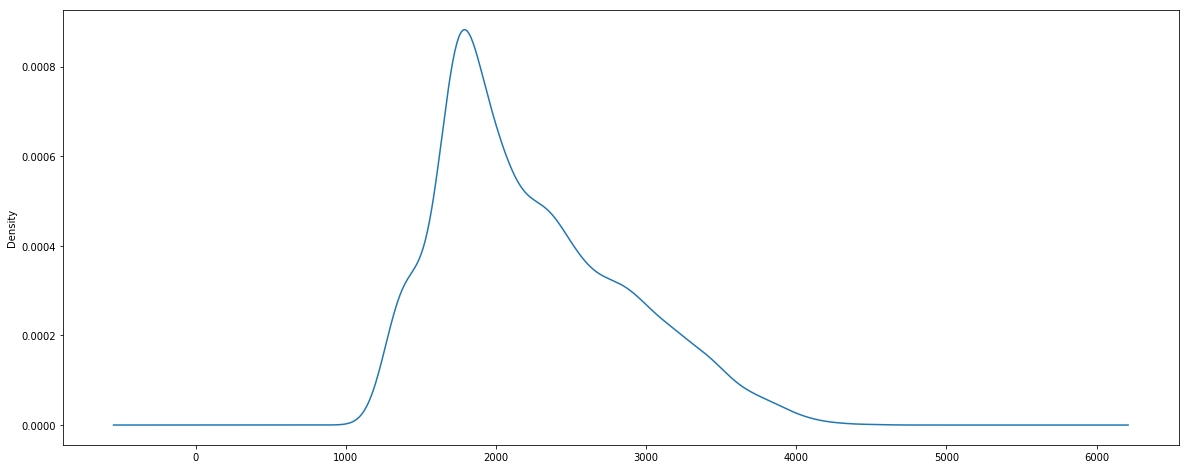

In [48]:
#df.AECI.plot(figsize=[20,8]) 
#df.iloc[:,2].plot(figsize = [20,8])
#df.iloc[0:2000:,2].plot(figsize = [20,8])
#df.iloc[8000:,2].plot(figsize = [20,8]) # i think this is fine, no correction ofr miso/aeci

import seaborn as sns
#sns.kdeplot(fixed_winter_m3['delta_zscore'])
df.iloc[:,2].plot(kind="kde", figsize = [20,8]) #this  is an indication why 3 zscore cut off isn't working well. 5 is ok 


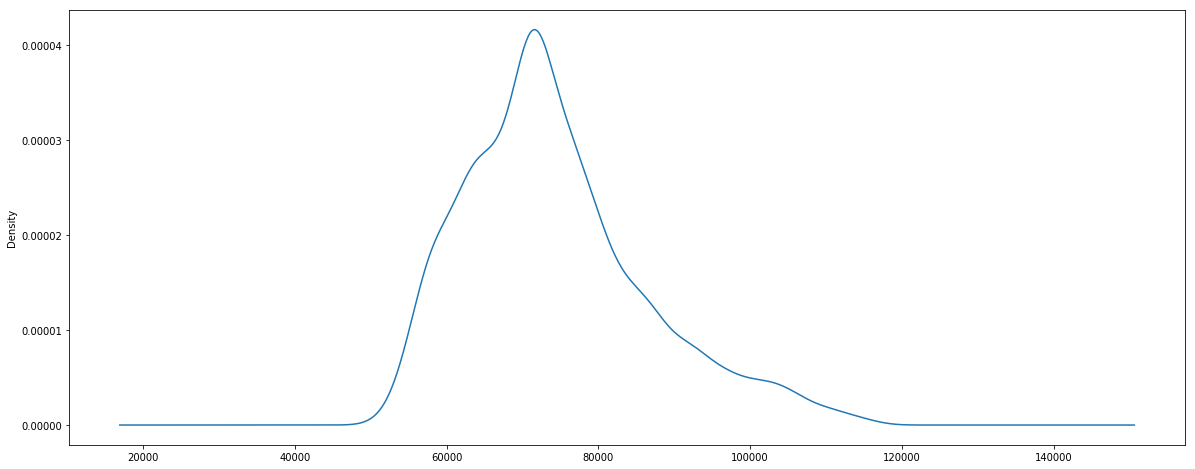

In [49]:
df.iloc[:,1].plot(kind="kde", figsize = [20,8]) 

In [71]:
df1 = slope_interpolate(df.iloc[:,2:3])
#print(len(fixed_fall_m3.loc[fixed_fall_m3['delta_zscore']>3])) #2
#df1.iloc[:,2].plot(kind="kde", figsize = [20,8]) 
#df1

print(len(df1.loc[df1['delta_zscore']>5])) 

95 2614.0 2614.0
96 2989.0 2989.0
1260 2232.0 2232.0
1261 2613.0 2613.0
2963 1485.0 1485.0
2964 1886.0 1886.0
3220 1891.0 1891.0
3221 1506.0 1506.0
4012 3033.0 3033.0
4013 2659.0 2659.0
4909 2182.0 2182.0
4910 2566.0 2566.0
5019 2979.0 2979.0
5020 2605.0 2605.0
5691 2995.0 2995.0
5692 2615.0 2615.0
5715 2790.0 2790.0
5716 2344.0 2344.0
8471 3689.0 3689.0
8472 4099.0 4099.0
8495 3271.0 3271.0
8496 3650.0 3650.0
end


In [76]:
df1 = slope_interpolate(df.iloc[:,2:3])
#print(len(fixed_fall_m3.loc[fixed_fall_m3['delta_zscore']>3])) #2
#df1.iloc[:,2].plot(kind="kde", figsize = [20,8]) 
#df1

print(len(df1.loc[df1['delta_zscore']>5])) 
df1

95 2614.0 2614.0
96 2989.0 2989.0
1260 2232.0 2232.0
1261 2613.0 2613.0
2963 1485.0 1485.0
2964 1886.0 1886.0
3220 1891.0 1891.0
3221 1506.0 1506.0
4012 3033.0 3033.0
4013 2659.0 2659.0
4909 2182.0 2182.0
4910 2566.0 2566.0
5019 2979.0 2979.0
5020 2605.0 2605.0
5691 2995.0 2995.0
5692 2615.0 2615.0
5715 2790.0 2790.0
5716 2344.0 2344.0
8471 3689.0 3689.0
8472 4099.0 4099.0
8495 3271.0 3271.0
8496 3650.0 3650.0


,AECI,delta,delta_zscore
2016-01-01 00:00:00+00:00,2917.0,NaN,NaN
2016-01-01 01:00:00+00:00,2946.0,29.0,0.234067
2016-01-01 02:00:00+00:00,2910.0,-36.0,0.288852
2016-01-01 03:00:00+00:00,2878.0,-32.0,0.256672
2016-01-01 04:00:00+00:00,2829.0,-49.0,0.393436
...,...,...,...
2016-12-31 19:00:00+00:00,2178.0,-144.0,1.157702
2016-12-31 20:00:00+00:00,2094.0,-84.0,0.675007
2016-12-31 21:00:00+00:00,2035.0,-59.0,0.473885
2016-12-31 22:00:00+00:00,2035.0,0.0,0.000765


In [91]:
df1 = slope_interpolate(df.iloc[:,2:3])

In [92]:
len(df1[df1['delta_zscore']>5])

0

In [77]:
df1

,AECI,delta,delta_zscore
2016-01-01 00:00:00+00:00,2917.0,NaN,NaN
2016-01-01 01:00:00+00:00,2946.0,29.0,0.234067
2016-01-01 02:00:00+00:00,2910.0,-36.0,0.288852
2016-01-01 03:00:00+00:00,2878.0,-32.0,0.256672
2016-01-01 04:00:00+00:00,2829.0,-49.0,0.393436
...,...,...,...
2016-12-31 19:00:00+00:00,2178.0,-144.0,1.157702
2016-12-31 20:00:00+00:00,2094.0,-84.0,0.675007
2016-12-31 21:00:00+00:00,2035.0,-59.0,0.473885
2016-12-31 22:00:00+00:00,2035.0,0.0,0.000765


In [ ]:
print(len(fixed_winter_m3.loc[fixed_winter_m3['delta_zscore']>3])) #confirmed no anomalies

In [54]:
# Assign a list of BA into BA areas we defined above
BA_area ={
    'ISNE':['ISNE'],
    'NYIS':['NYIS'],
    'PJM':['PJM','OVEC'],
    'AEC':['AEC'],
    'SOCO':['SOCO'],
    'TVA_LGEE':['TVA','LGEE'],
    'Florida':['TAL','JEA','GVL','SEC','FPC','NSB','FMPP','TEC','FPL','HST'],
    'MISO':['MISO','AECI'],
    'SWPP':['SWPP','SPA'],
    'Carolina':['CPLW','DUK','SCEG','SC','CPLE']
}

eastern_agg_demand = pd.DataFrame(index=eastern_demand_2016.index)
for key in BA_area:
    print(key)
    print(eastern_demand_2016[BA_area[key]].shape[1])
    if eastern_demand_2016[BA_area[key]].shape[1] > 1:
        eastern_agg_demand[key] = eastern_demand_2016[BA_area[key]].sum(axis=1)
    else:
        eastern_agg_demand[key] = eastern_demand_2016[BA_area[key]]

ISNE
1
NYIS
1
PJM
2
AEC
1
SOCO
1
TVA_LGEE
2
Florida
10
MISO
2
SWPP
2
Carolina
5


C:\Users\vhunt\AppData\Roaming\Python\Python37\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


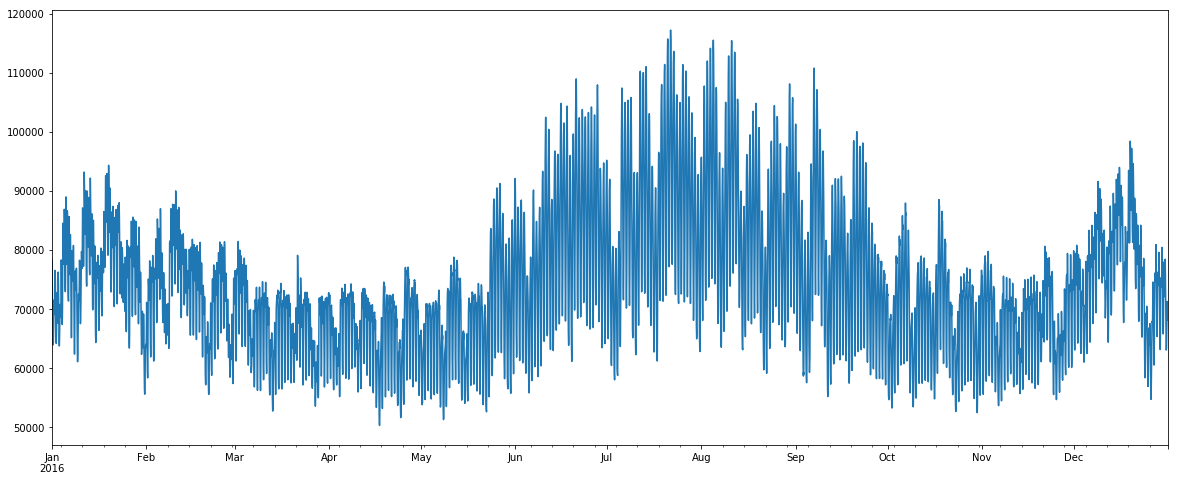

In [18]:
%matplotlib inline
df_MISO.MISO.plot(figsize=[20,8]) #no obvious outliers but will look season by season

In [28]:
df_MISO.index

DatetimeIndex(['2016-01-01 00:00:00+00:00', '2016-01-01 01:00:00+00:00',
               '2016-01-01 02:00:00+00:00', '2016-01-01 03:00:00+00:00',
               '2016-01-01 04:00:00+00:00', '2016-01-01 05:00:00+00:00',
               '2016-01-01 06:00:00+00:00', '2016-01-01 07:00:00+00:00',
               '2016-01-01 08:00:00+00:00', '2016-01-01 09:00:00+00:00',
               ...
               '2016-12-31 14:00:00+00:00', '2016-12-31 15:00:00+00:00',
               '2016-12-31 16:00:00+00:00', '2016-12-31 17:00:00+00:00',
               '2016-12-31 18:00:00+00:00', '2016-12-31 19:00:00+00:00',
               '2016-12-31 20:00:00+00:00', '2016-12-31 21:00:00+00:00',
               '2016-12-31 22:00:00+00:00', '2016-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8784, freq='H')

In [35]:
#datadir = os.path.join('..', 'test', 'data')
#BA = pd.read_csv(datadir + "/" + 'BA_2016.csv', index_col='UTC Time', parse_dates=True )

#vh note; needed to add time zone var, 4 lines below

winter_index = pd.date_range('2016-01-03 00:00:00','2016-03-31 23:00:00', freq='1H', tz = "UTC")
spring_index = pd.date_range('2016-04-01 00:00:00','2016-06-30 23:00:00', freq='1H', tz = "UTC")
summer_index = pd.date_range('2016-07-01 00:00:00','2016-09-30 23:00:00', freq='1H', tz = "UTC")
fall_index = pd.date_range('2016-10-01 00:00:00','2016-12-31 23:00:00', freq='1H', tz = "UTC")

winter = df_MISO.loc[winter_index]
spring = df_MISO.loc[spring_index]
summer = df_MISO.loc[summer_index]
fall = df_MISO.loc[fall_index]

winter['weekday_hour'] = winter.index.to_series().apply(lambda x: str(x.dayofweek) + "_" + str(x.hour))
spring['weekday_hour'] = spring.index.to_series().apply(lambda x: str(x.dayofweek) + "_" + str(x.hour))
summer['weekday_hour'] = summer.index.to_series().apply(lambda x: str(x.dayofweek) + "_" + str(x.hour))
fall['weekday_hour'] = fall.index.to_series().apply(lambda x: str(x.dayofweek) + "_" + str(x.hour))

winter_weekday_hour_mean = winter.groupby('weekday_hour').mean()
winter_weekday_hour_std = winter.groupby('weekday_hour').std()
spring_weekday_hour_mean = spring.groupby('weekday_hour').mean()
spring_weekday_hour_std = spring.groupby('weekday_hour').std()
summer_weekday_hour_mean = summer.groupby('weekday_hour').mean()
summer_weekday_hour_std = summer.groupby('weekday_hour').std()
fall_weekday_hour_mean = fall.groupby('weekday_hour').mean()
fall_weekday_hour_std = fall.groupby('weekday_hour').std()

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  app.launch_new_instance()
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series w

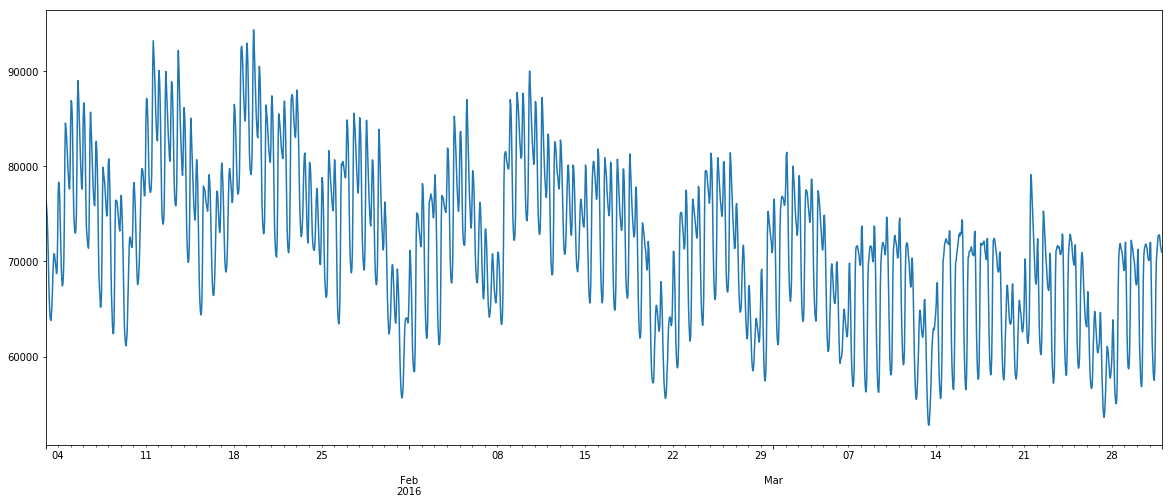

In [25]:
#fall['MISO'].plot()
winter['MISO'].plot(figsize=[20,8])



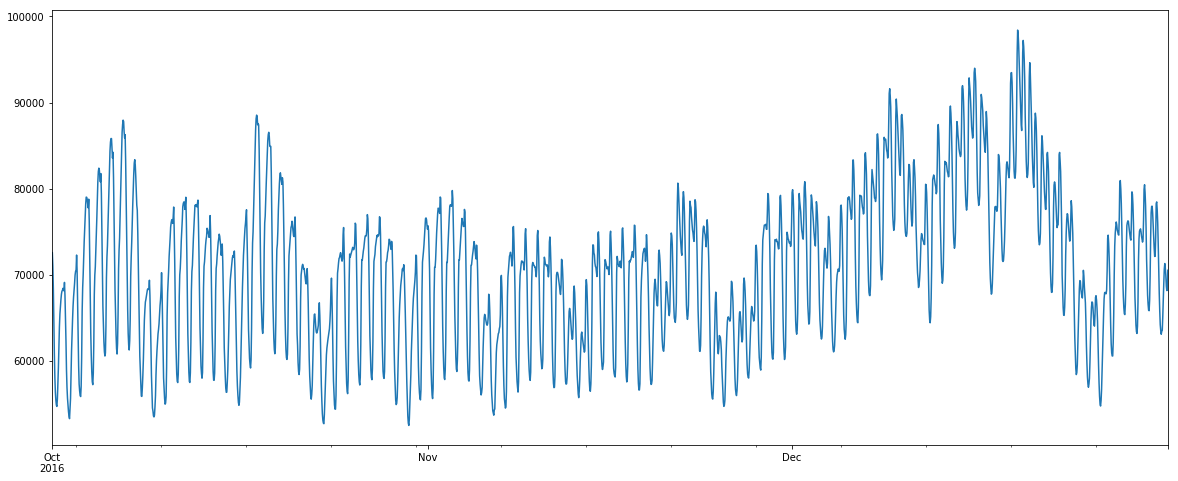

In [26]:
fall['MISO'].plot(figsize=[20,8])

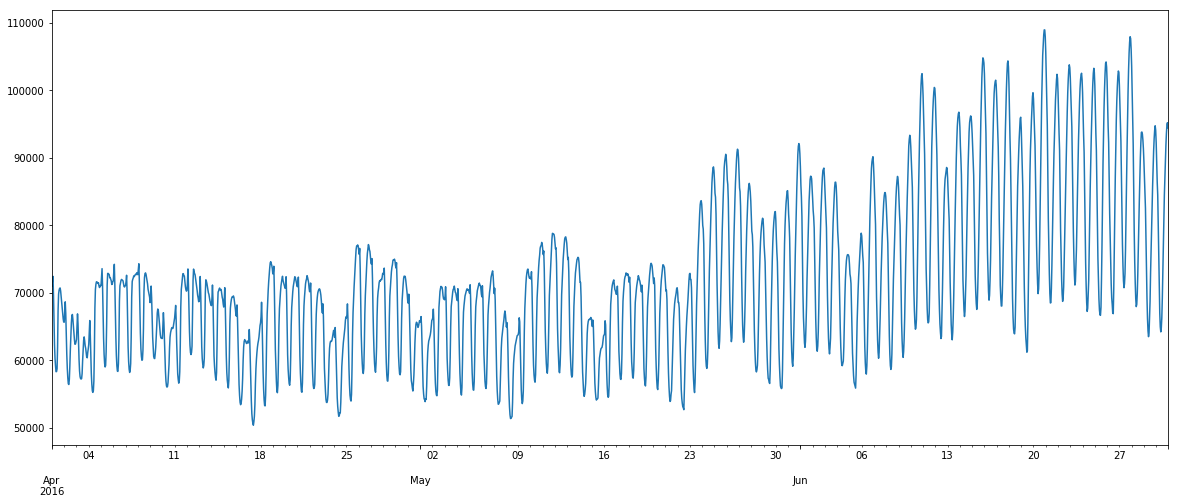

In [27]:
spring['MISO'].plot(figsize=[20,8])

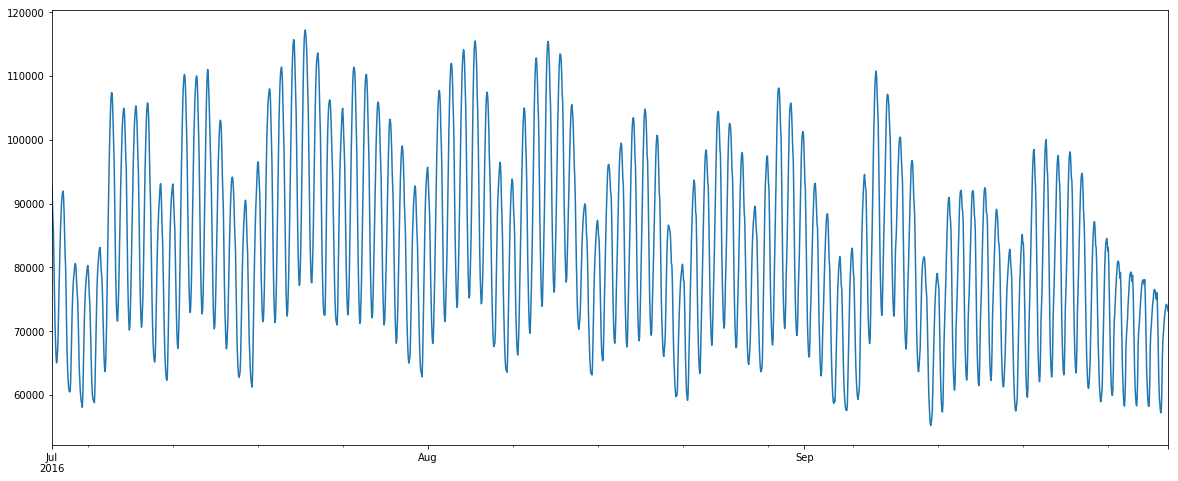

In [29]:
summer['MISO'].plot(figsize=[20,8])

In [36]:
orig_fall = fall[['MISO','weekday_hour']]
orig_fall2 = fall['MISO'].to_frame().copy()
orig_winter = winter[['MISO','weekday_hour']]
orig_winter2 = winter['MISO'].to_frame().copy()
orig_summer = summer[['MISO','weekday_hour']]
orig_summer2 = summer['MISO'].to_frame().copy()
orig_spring = spring[['MISO','weekday_hour']]
orig_spring2 = spring['MISO'].to_frame().copy()
fixed_fall_m3 = slope_interpolate(orig_fall2)
print(len(fixed_fall_m3.loc[fixed_fall_m3['delta_zscore']>5]))
 #confirmed no anomalies

fixed_winter_m3 = slope_interpolate(orig_winter2)
print(len(fixed_winter_m3.loc[fixed_winter_m3['delta_zscore']>5])) #confirmed no anomalies

fixed_spring_m3 = slope_interpolate(orig_spring2)
print(len(fixed_spring_m3.loc[fixed_spring_m3['delta_zscore']>5])) #confirmed no anomalies

fixed_summer_m3 = slope_interpolate(orig_summer2)
print(len(fixed_summer_m3.loc[fixed_summer_m3['delta_zscore']>5])) #confirmed no anomalies

395 63748.0 63748.0
396 70282.0 70282.0
563 60170.0 60170.0
564 67029.0 67029.0
587 62621.0 62621.0
588 69296.0 69296.0
611 61899.0 61899.0
612 68625.0 68625.0
731 61099.0 61099.0
732 67844.0 67844.0
755 61122.0 61122.0
756 67717.0 67717.0
1068 64496.0 64496.0
1069 71270.0 71270.0
1452 66272.0 66272.0
1453 72789.0 72789.0
1572 69334.0 69334.0
1573 76124.0 76124.0
1596 70019.0 70019.0
1597 76580.0 76580.0
1620 73221.0 73221.0
1621 79939.0 79939.0
1644 76282.0 76282.0
1645 83267.0 83267.0
1668 81602.0 81602.0
1669 88270.0 88270.0
1740 71043.0 71043.0
1741 78025.0 78025.0
1812 83537.0 83537.0
1813 90250.0 90250.0
0
36 74987.0 74987.0
37 81663.0 81663.0
60 80040.0 80040.0
61 86678.0 86678.0
204 84090.0 84090.0
205 90642.0 90642.0
228 80337.0 80337.0
229 87154.0 87154.0
252 83180.0 83180.0
253 89732.0 89732.0
396 85521.0 85521.0
397 91959.0 91959.0
564 70679.0 70679.0
565 77093.0 77093.0
588 76109.0 76109.0
589 82941.0 82941.0
612 75869.0 75869.0
613 82562.0 82562.0
636 74893.0 74893.0
637 

In [39]:
print(len(fixed_fall_m3.loc[fixed_fall_m3['delta_zscore']>3]))
print(len(fixed_winter_m3.loc[fixed_winter_m3['delta_zscore']>3]))
delta_zscor

15
22


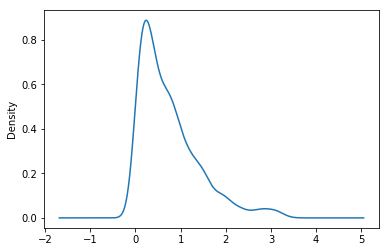

In [43]:
import seaborn as sns
#sns.kdeplot(fixed_winter_m3['delta_zscore'])
fixed_winter_m3['delta_zscore'].plot(kind="kde") #this  is an indication why 3 zscore cut off isn't working well. 5 is ok

In [33]:
orig_winter = winter[['MISO','weekday_hour']]
orig_winter2 = winter['MISO'].to_frame().copy()
fixed_winter_m3 = slope_interpolate(orig_winter2)
print(len(fixed_winter_m3.loc[fixed_winter_m3['delta_zscore']>3])) #confirmed no anomalies

KeyError: "['MISO'] not in index"

In [44]:
#datadir = os.path.join('..', 'test', 'data')
#BA = pd.read_csv(datadir + "/" + 'BA_2016.csv', index_col='UTC Time', parse_dates=True )

#vh note; needed to add time zone var, 4 lines below

winter = df_PJM.loc[winter_index]
spring = df_PJM.loc[spring_index]
summer = df_PJM.loc[summer_index]
fall = df_PJM.loc[fall_index]

winter['weekday_hour'] = winter.index.to_series().apply(lambda x: str(x.dayofweek) + "_" + str(x.hour))
spring['weekday_hour'] = spring.index.to_series().apply(lambda x: str(x.dayofweek) + "_" + str(x.hour))
summer['weekday_hour'] = summer.index.to_series().apply(lambda x: str(x.dayofweek) + "_" + str(x.hour))
fall['weekday_hour'] = fall.index.to_series().apply(lambda x: str(x.dayofweek) + "_" + str(x.hour))

winter_weekday_hour_mean = winter.groupby('weekday_hour').mean()
winter_weekday_hour_std = winter.groupby('weekday_hour').std()
spring_weekday_hour_mean = spring.groupby('weekday_hour').mean()
spring_weekday_hour_std = spring.groupby('weekday_hour').std()
summer_weekday_hour_mean = summer.groupby('weekday_hour').mean()
summer_weekday_hour_std = summer.groupby('weekday_hour').std()
fall_weekday_hour_mean = fall.groupby('weekday_hour').mean()
fall_weekday_hour_std = fall.groupby('weekday_hour').std()

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  if sys.path[0] == '':
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  del sys.path[0]
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:14: FutureWa

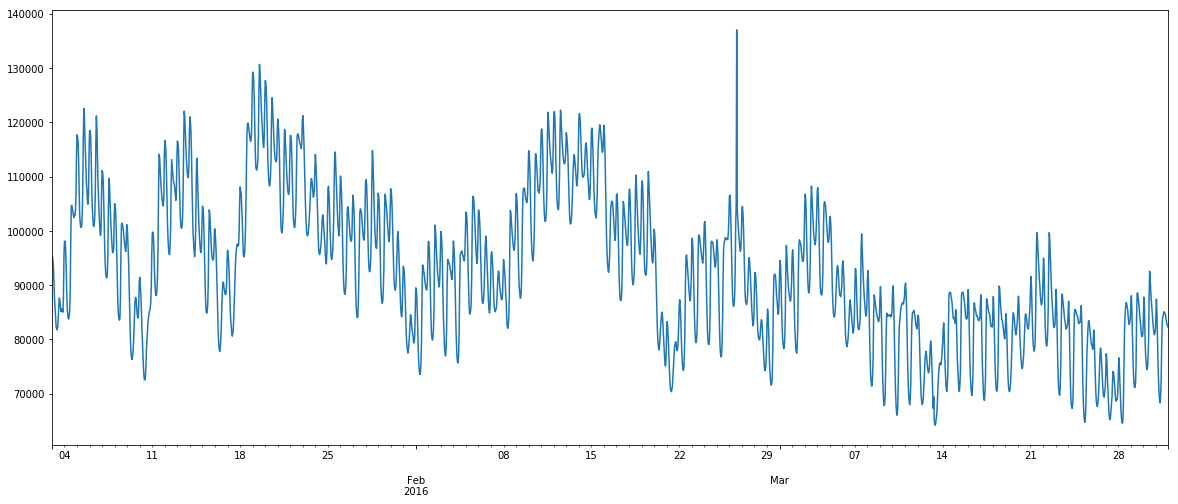

In [49]:
#df_PJM['PJM'].plot(figsize=[20,8])#looks like there is one anomaly, in feb/mar (winter)
winter['PJM'].plot(figsize=[20,8]) # 1 anomaly
#summer['PJM'].plot(figsize=[20,8]) #ok
#spring['PJM'].plot(figsize=[20,8]) #ok
#fall['PJM'].plot(figsize=[20,8])  #ok but possibly one outlier (?) in dec

In [70]:
orig_fall = fall[['PJM','weekday_hour']]
orig_fall2 = fall['PJM'].to_frame().copy()
orig_winter = winter[['PJM','weekday_hour']]
orig_winter2 = winter['PJM'].to_frame().copy()
orig_summer = summer[['PJM','weekday_hour']]
orig_summer2 = summer['PJM'].to_frame().copy()
orig_spring = spring[['PJM','weekday_hour']]
orig_spring2 = spring['PJM'].to_frame().copy()

fixed_fall_m3 = slope_interpolate(orig_fall2)
print(len(fixed_fall_m3.loc[fixed_fall_m3['delta_zscore']>3])) #2

fixed_winter_m3 = slope_interpolate(orig_winter2)
print(len(fixed_winter_m3.loc[fixed_winter_m3['delta_zscore']>3])) #2

fixed_spring_m3 = slope_interpolate(orig_spring2)
print(len(fixed_spring_m3.loc[fixed_spring_m3['delta_zscore']>3])) #2

fixed_summer_m3 = slope_interpolate(orig_summer2)
print(len(fixed_summer_m3.loc[fixed_summer_m3['delta_zscore']>3])) #2

250 70540.0 70540.0
251 79024.0 79024.0
586 72544.0 72544.0
587 81143.0 81143.0
610 76164.0 76164.0
611 84812.0 84812.0
658 71985.0 71985.0
659 80404.0 80404.0
899 74791.0 74791.0
900 83695.0 83695.0
971 77999.0 77999.0
972 86566.0 86566.0
1067 82872.0 82872.0
1068 91992.0 91992.0
1091 78373.0 78373.0
1092 87148.0 87148.0
1115 79518.0 79518.0
1116 88453.0 88453.0
1139 78624.0 78624.0
1140 87057.0 87057.0
1235 88661.0 88661.0
1236 97476.0 97476.0
1403 84185.0 84185.0
1404 92698.0 92698.0
1571 83392.0 83392.0
1572 91813.0 91813.0
1667 97837.0 97837.0
1668 106288.0 106288.0
1787 94217.0 94217.0
1788 102829.0 102829.0
1811 102802.0 102802.0
1812 111919.0 111919.0
1822 120761.0 120761.0
1823 129580.0 129580.0
1907 98888.0 98888.0
1908 107472.0 107472.0
18
83 89401.0 89401.0
84 98774.0 98774.0
251 97783.0 97783.0
252 107805.0 107805.0
299 107719.0 107719.0
300 116714.0 116714.0
659 100431.0 100431.0
660 109371.0 109371.0
779 86490.0 86490.0
780 95837.0 95837.0
851 91481.0 91481.0
852 100452.

0


In [96]:
def conditionalfill(row, df):
    currentDatetimeInd = row.index
    dayOfWeek = row['dayofweek']
    
    backOne = currentDatetimeInd.shift(-1,'D')
    backRow = df.loc[backOne]
    
    forwardOne = currentDatetimeInd.shift(1,'D')
    forwardRow = df.loc[forwardOne]
    
    if backRow.dayofweek < 5 and forwardRow.dayofweek < 5:
        naMask = row.isna()
        row[naMask] = (backRow[naMask] + forwardRow[naMask])/2

In [97]:
from functools import partial

fillRow = partial(conditionalfill, eastern_demand_2016)

In [99]:
eastern_demand_2016['dayofweek'] = eastern_demand_2016.index.dayofweek 

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
eastern_demand_2016.dayofweek

2016-01-01 00:00:00+00:00    4
2016-01-01 01:00:00+00:00    4
2016-01-01 02:00:00+00:00    4
2016-01-01 03:00:00+00:00    4
2016-01-01 04:00:00+00:00    4
                            ..
2016-12-31 19:00:00+00:00    5
2016-12-31 20:00:00+00:00    5
2016-12-31 21:00:00+00:00    5
2016-12-31 22:00:00+00:00    5
2016-12-31 23:00:00+00:00    5
Name: dayofweek, Length: 8784, dtype: int64

In [101]:
eastern_demand_2016.apply(fillRow)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


AttributeError: ("'Series' object has no attribute 'dayofweek'", 'occurred at index SWPP')

In [44]:
eastern_demand_2016.columns

Index(['SWPP', 'MISO', 'AECI', 'SPA', 'LGEE', 'OVEC', 'PJM', 'NYIS', 'ISNE',
       'TVA', 'CPLW', 'DUK', 'CPLE', 'AEC', 'SOCO', 'SC', 'TAL', 'SCEG', 'GVL',
       'JEA', 'SEC', 'FPC', 'NSB', 'TEC', 'FMPP', 'FPL', 'HST', 'dayofweek'],
      dtype='object')

In [182]:
eastern_demand_2016.isnull().sum(axis=0)
#MISO, PJM, ISNE, TVA,CPLW,CPLE,SOCO SC JEA SEC FPC NSB TEC FMPP FPL HST
list0 = eastern_demand_2016.isnull().sum(axis=0)
list0[list0 >0]

MISO      11
OVEC    2938
PJM       26
ISNE       3
TVA       23
CPLW      23
CPLE      23
SOCO     241
SC        25
JEA        6
SEC       96
FPC       23
NSB      186
FMPP     258
FPL       35
HST      192
dtype: int64

In [30]:
def conditionalfill(row, df):
    dayOfWeek = row['dayofweek']
    
    backOne = df.shift(-1,'D')
    backRow = df.loc[backOne]
    
    forwardOne = df.shift(1,'D')
    forwardRow = df.loc[forwardOne]
    
    if backRow.dayofweek < 5 and forwardRow.dayofweek < 5:
        naMask = row.isna()
        row[naMask] = (backRow[naMask] + forwardRow[naMask])/2

In [31]:
for index, row in eastern_demand_2016.iterrows():
    newrow = conditionalfill(row, eastern_demand_2016 )
    print(newrow)

ValueError: Cannot index with multidimensional key